In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config.config import LSTM_DATA_DIR, OBSERVACIONS_FILTRAT_DIR, LSTM_PREDICTIONS_DIR, OBSERVACIONS_DIR, AUTOENCODER_DIR
import pandas as pd
import os
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras import regularizers
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import joblib
from src.LSTM import flatten, scale_data_anomaly_detection

In [3]:
#get all the files in the directory
files = os.listdir(LSTM_PREDICTIONS_DIR)

In [4]:
data_all_stations = []
data_all_stations_test = []
normalization_features = []
input_length = 14

#read all the files that are csv
for file in files:
    if file.endswith(".csv"):


        df = pd.read_csv(os.path.join(LSTM_PREDICTIONS_DIR / file))

        df['ds'] = pd.to_datetime(df['ds'])

        #marquem com a anomalia els valors que son nans al fitxer observacions_filtrat pero no al fitxer observacions original
        df_observacions_originals = pd.read_csv(os.path.join(OBSERVACIONS_DIR / file), parse_dates = ['Date'])
        df_observacions_filtrades = pd.read_csv(os.path.join(OBSERVACIONS_FILTRAT_DIR / file), parse_dates = ['Date'])

        df_observacions_originals.rename(columns = {'Date': 'ds', 'Flow': 'y_original'}, inplace = True)
        df_observacions_filtrades.rename(columns = {'Date': 'ds', 'Flow': 'y_original_filtrades'}, inplace = True)

        df = df.merge(df_observacions_originals, on = 'ds', how = 'left')
        df = df.merge(df_observacions_filtrades, on = 'ds', how = 'left')


        #add column is anomaly, if y_original is not na and y_original_filtrades is na, then is anomaly
        #df['is_anomaly'] = df['y_original'].notna() & df['y_original_filtrades'].isna()
        df['is_anomaly'] = df['y_original_filtrades'].isna()    #train autoencoder without anomaly or empty data

        #Afegim els 150 de la finestra de look-back (traiem l'últim 15% tenint en compte la serie sencera)
        n = len(df) + 150 

        df_train = df[:int(n*0.85)]
        df_test = df[int(n*0.85):]


        #duplicate last row with concat
        df_train = pd.concat([df_train, df_train.iloc[[-1]]])
        df_test = pd.concat([df_test, df_test.iloc[[-1]]])

        #move is_anomaly values to next row. That way, generator will return [(sliding window of 14 values, is_anomaly of 14th value))]
        df_train['is_anomaly'] = df_train['is_anomaly'].shift(+1)
        df_test['is_anomaly'] = df_test['is_anomaly'].shift(+1)

        generator = TimeseriesGenerator(df_train[['y', 'yhat']].values, df_train['is_anomaly'].values, length=14, batch_size=1)
        test_generator = TimeseriesGenerator(df_test[['y', 'yhat']].values, df_test['is_anomaly'].values, length=14, batch_size=1)


        merged_generator = np.array([sample[0][0] for sample in generator if not sample[1][0]])
        merged_generator_test = np.array([sample[0][0] for sample in test_generator if not sample[1][0]])

        data_all_stations.extend(merged_generator)
        data_all_stations_test.extend(merged_generator_test)

In [5]:
X_train = scale_data_anomaly_detection(data_all_stations)
X_test = scale_data_anomaly_detection(data_all_stations_test)

In [6]:
def autoencoder_model(X):
    inputs = Input(shape = (X.shape[1], X.shape[2]))
    L1 = LSTM(32, return_sequences=True)(inputs)
    L2 = LSTM(16, return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, return_sequences=True)(L3)
    L5 = LSTM(32, return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [7]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 2)]           0         
                                                                 
 lstm (LSTM)                 (None, 14, 32)            4480      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 14, 16)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 14, 16)            2112      
                                                                 
 lstm_3 (LSTM)               (None, 14, 32)            6272      
                                                             

In [8]:
nb_epochs = 50
batch_size = 64
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.2).history

Epoch 1/50
2171/2171 [==============================] - 27s 10ms/step - loss: 0.1030 - val_loss: 0.0856
Epoch 2/50
2171/2171 [==============================] - 21s 10ms/step - loss: 0.0810 - val_loss: 0.0765
Epoch 3/50
2171/2171 [==============================] - 22s 10ms/step - loss: 0.0739 - val_loss: 0.0693
Epoch 4/50
2171/2171 [==============================] - 22s 10ms/step - loss: 0.0694 - val_loss: 0.0666
Epoch 5/50
2171/2171 [==============================] - 21s 10ms/step - loss: 0.0676 - val_loss: 0.0659
Epoch 6/50
2171/2171 [==============================] - 21s 10ms/step - loss: 0.0657 - val_loss: 0.0620
Epoch 7/50
2171/2171 [==============================] - 21s 10ms/step - loss: 0.0613 - val_loss: 0.0570
Epoch 8/50
2171/2171 [==============================] - 22s 10ms/step - loss: 0.0583 - val_loss: 0.0553
Epoch 9/50
2171/2171 [==============================] - 21s 10ms/step - loss: 0.0567 - val_loss: 0.0543
Epoch 10/50
2171/2171 [==============================] - 21s 10m

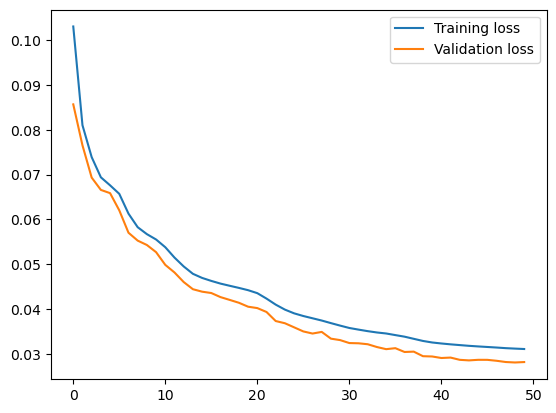

In [9]:
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()


Reconstruction error threshold: 0.250201940536499


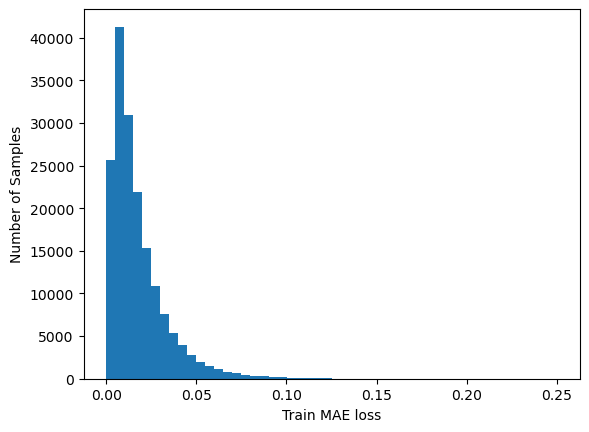

In [10]:
#Find MAE loss on training samples
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(flatten(X_train_pred) - flatten(X_train)), axis=1)


plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')


In [11]:
#90 percentile
threshold = np.percentile(train_mae_loss, 95)
print(f'Reconstruction error threshold on 90 percentile: {threshold}')

Reconstruction error threshold on 90 percentile: 0.048849263990422345


In [12]:
#store model
model.save(AUTOENCODER_DIR / 'lstm_autoencoder.h5')

#store scaler
#joblib.dump(scaler, AUTOENCODER_DIR / 'scaler.pkl')